<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/QMAML_for_Quark_Gluon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
! pip install pennylane h5py --quiet

In [73]:
# Cell 1: Imports and Setup
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# Cell 2: Configuration / Hyperparameter Setup
@dataclass
class Config:
    SAMPLES: int = 20000  # Increased max number of samples to load
    NUM_QUBITS: int = 6  # Increased number of qubits in PQC
    Q_DEPTH: int = 4  # Increased depth of quantum circuit
    CNN_OUTPUT_DIM: int = 128  # Increased output dimension of CNN feature extractor
    INNER_STEPS: int = 10  # Increased steps for inner-loop adaptation
    INNER_LR: float = 0.005  # Slightly reduced learning rate for inner-loop
    OUTER_LR: float = 0.0005  # Slightly reduced learning rate for outer-loop
    META_TASK_TYPE: str = 'pt'  # Meta-task type ('pt' or 'm0')
    META_BIN_COUNT: int = 15  # Increased number of bins for meta-task generation
    SUPPORT_SIZE: int = 64  # Increased support set size
    QUERY_SIZE: int = 64  # Increased query set size
    EPOCHS: int = 50  # Increased number of meta-training epochs
    BATCH_SIZE: int = 128  # Increased batch size for DataLoader
    EVAL_METRICS: bool = True  # Toggle for tracking metrics
    USE_TEST2: bool = True  # Flag to evaluate on test2

config = Config()

In [75]:
# Cell 3: Dataset Loading and Merging
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_and_merge_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and merge datasets for meta-task generation."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'
    test2_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n10000.hdf5'

    # Load train and test1 datasets
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    with h5py.File(test1_path, 'r') as f:
        X_test1 = f['X_jets'][:config.SAMPLES]
        y_test1 = f['y'][:config.SAMPLES]
        pt_test1 = f['pt'][:config.SAMPLES]
        m0_test1 = f['m0'][:config.SAMPLES]

    # Merge train and test1
    X_meta = np.concatenate([X_train, X_test1], axis=0)
    y_meta = np.concatenate([y_train, y_test1], axis=0)
    pt_meta = np.concatenate([pt_train, pt_test1], axis=0)
    m0_meta = np.concatenate([m0_train, m0_test1], axis=0)

    # Load test2 dataset
    with h5py.File(test2_path, 'r') as f:
        X_test2 = f['X'][:config.SAMPLES]  # Use 'X' instead of 'X_jets'
        y_test2 = f['y'][:config.SAMPLES]

    # Create datasets
    meta_dataset = JetDataset(X_meta, y_meta, pt_meta, m0_meta)
    test2_dataset = JetDataset(X_test2, y_test2)

    return meta_dataset, test2_dataset

# Load datasets
meta_dataset, test2_dataset = load_and_merge_datasets(config)

In [76]:
# Cell 4: Define CNN-based Feature Extractor
class CNNFeatureExtractor(nn.Module):
    """CNN-based feature extractor for jet images."""
    def __init__(self, output_dim: int):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(64 * 15 * 15, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Permute dimensions to match PyTorch's expected input format
        x = x.permute(0, 3, 1, 2)  # From (batch_size, height, width, channels) to (batch_size, channels, height, width)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.contiguous().view(x.size(0), -1)  # Ensure tensor is contiguous before flattening
        x = self.fc(x)
        return x

cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM)

In [77]:
# Cell 5: Define PQC Quantum Model
class PQCModel(nn.Module):
    """Parameterized Quantum Circuit (PQC) model."""
    def __init__(self, num_qubits: int, depth: int):
        super(PQCModel, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
            # Angle encoding
            for i in range(num_qubits):
                qml.RY(inputs[i], wires=i)
            # Variational layers
            qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return qml.expval(qml.PauliZ(0))  # Expectation value of Z on the first qubit

        self.circuit = circuit
        self.weights = nn.Parameter(torch.randn(depth, num_qubits, 3))
        self.fc = nn.Linear(1, 2)  # Map scalar output to two logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply the quantum circuit
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1)  # Placeholder for quantum outputs
        for i in range(batch_size):
            outputs[i] = self.circuit(x[i], self.weights)
        # Map the scalar output to two logits
        logits = self.fc(outputs)
        return logits

pqc_model = PQCModel(config.NUM_QUBITS, config.Q_DEPTH)

In [78]:
# Cell 6: Combine CNN + PQC into HybridModel
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super(HybridModel, self).__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

hybrid_model = HybridModel(cnn_extractor, pqc_model)

In [79]:
# Cell 7: Meta-task Generation Logic
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_type: str,
    bin_count: int,
    support_size: int,
    query_size: int,
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks by binning samples based on meta_task_type ('pt' or 'm0').

    Args:
        dataset: The dataset containing jet images and labels.
        meta_task_type: The feature to bin samples on ('pt' or 'm0').
        bin_count: Number of bins for meta-task generation.
        support_size: Number of samples in the support set.
        query_size: Number of samples in the query set.

    Returns:
        A list of meta-tasks, each containing support and query sets.
    """
    # Extract features and labels
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    # Bin samples based on meta_task_type
    if meta_task_type == 'pt':
        feature = dataset.pt
    elif meta_task_type == 'm0':
        feature = dataset.m0
    else:
        raise ValueError("Invalid meta_task_type. Choose 'pt' or 'm0'.")

    bins = np.linspace(feature.min(), feature.max(), bin_count + 1)
    meta_tasks = []

    for i in range(bin_count):
        # Get indices of samples in the current bin
        bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
        if len(bin_indices) < support_size + query_size:
            continue  # Skip bins with insufficient samples

        # Randomly sample support and query sets
        np.random.shuffle(bin_indices)
        support_indices = bin_indices[:support_size]
        query_indices = bin_indices[support_size : support_size + query_size]

        meta_tasks.append(
            {
                "support_X": torch.tensor(X[support_indices], dtype=torch.float32),
                "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                "query_X": torch.tensor(X[query_indices], dtype=torch.float32),
                "query_y": torch.tensor(y[query_indices], dtype=torch.long),
            }
        )

    return meta_tasks

meta_tasks = generate_meta_tasks(
    meta_dataset,
    config.META_TASK_TYPE,
    config.META_BIN_COUNT,
    config.SUPPORT_SIZE,
    config.QUERY_SIZE,
)

In [80]:
# Cell 8: Inner-loop Adaptation
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> nn.Module:
    """
    Perform inner-loop adaptation on the support set.

    Args:
        model: The hybrid model to adapt.
        support_X: Support set inputs.
        support_y: Support set labels.
        inner_steps: Number of inner-loop optimization steps.
        inner_lr: Learning rate for inner-loop.

    Returns:
        Adapted model with updated parameters.
    """
    adapted_model = HybridModel(model.cnn, model.pqc)  # Clone the model
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()
        optimizer.step()

    return adapted_model

In [69]:
# Cell 9: Outer-loop Meta-update (Fixed)
def outer_loop_meta_update(
    model: nn.Module,
    meta_tasks: List[Dict[str, Any]],
    outer_lr: float,
    eval_metrics: bool,
) -> Dict[str, List[float]]:
    """
    Perform outer-loop meta-update using meta-tasks.

    Args:
        model: The hybrid model to update.
        meta_tasks: List of meta-tasks.
        outer_lr: Learning rate for outer-loop.
        eval_metrics: Whether to track evaluation metrics.

    Returns:
        A dictionary containing meta-loss and evaluation metrics over epochs.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr)
    loss_fn = nn.CrossEntropyLoss()

    meta_loss_history = []
    metrics_history = {"accuracy": []}

    for epoch in range(config.EPOCHS):
        meta_loss = 0.0
        epoch_accuracies = []  # Track accuracies for each task in the epoch

        for task in meta_tasks:
            # Inner-loop adaptation
            adapted_model = inner_loop_adaptation(
                model,
                task["support_X"],
                task["support_y"],
                config.INNER_STEPS,
                config.INNER_LR,
            )

            # Evaluate on query set
            query_logits = adapted_model(task["query_X"])
            query_loss = loss_fn(query_logits, task["query_y"])
            meta_loss += query_loss.item()

            # Backpropagate meta-loss
            optimizer.zero_grad()
            query_loss.backward()
            optimizer.step()

            # Track per-task metrics
            if eval_metrics:
                preds = torch.argmax(query_logits, dim=1)
                accuracy = (preds == task["query_y"]).float().mean().item()
                epoch_accuracies.append(accuracy)

        # Store per-epoch meta-loss
        meta_loss /= len(meta_tasks)
        meta_loss_history.append(meta_loss)

        # Store average accuracy for this epoch
        if eval_metrics:
            avg_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
            metrics_history["accuracy"].append(avg_accuracy)

        print(f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return {"meta_loss": meta_loss_history, "accuracy": metrics_history["accuracy"]}


training_results = outer_loop_meta_update(
    hybrid_model, meta_tasks, config.OUTER_LR, config.EVAL_METRICS
)

Epoch 1/50, Meta-loss: 0.7456, Accuracy: 0.4427
Epoch 2/50, Meta-loss: 0.7157, Accuracy: 0.4427
Epoch 3/50, Meta-loss: 0.7040, Accuracy: 0.4427
Epoch 4/50, Meta-loss: 0.6967, Accuracy: 0.4427
Epoch 5/50, Meta-loss: 0.6920, Accuracy: 0.5365
Epoch 6/50, Meta-loss: 0.6895, Accuracy: 0.5573
Epoch 7/50, Meta-loss: 0.6877, Accuracy: 0.5573
Epoch 8/50, Meta-loss: 0.6870, Accuracy: 0.5573
Epoch 9/50, Meta-loss: 0.6867, Accuracy: 0.5573
Epoch 10/50, Meta-loss: 0.6867, Accuracy: 0.5573
Epoch 11/50, Meta-loss: 0.6869, Accuracy: 0.5573
Epoch 12/50, Meta-loss: 0.6902, Accuracy: 0.5573
Epoch 13/50, Meta-loss: 0.6872, Accuracy: 0.5573
Epoch 14/50, Meta-loss: 0.6869, Accuracy: 0.5573
Epoch 15/50, Meta-loss: 0.6870, Accuracy: 0.5573
Epoch 16/50, Meta-loss: 0.6872, Accuracy: 0.5573
Epoch 17/50, Meta-loss: 0.6872, Accuracy: 0.5573
Epoch 18/50, Meta-loss: 0.6873, Accuracy: 0.5573
Epoch 19/50, Meta-loss: 0.6866, Accuracy: 0.5573
Epoch 20/50, Meta-loss: 0.6862, Accuracy: 0.5573
Epoch 21/50, Meta-loss: 0.685

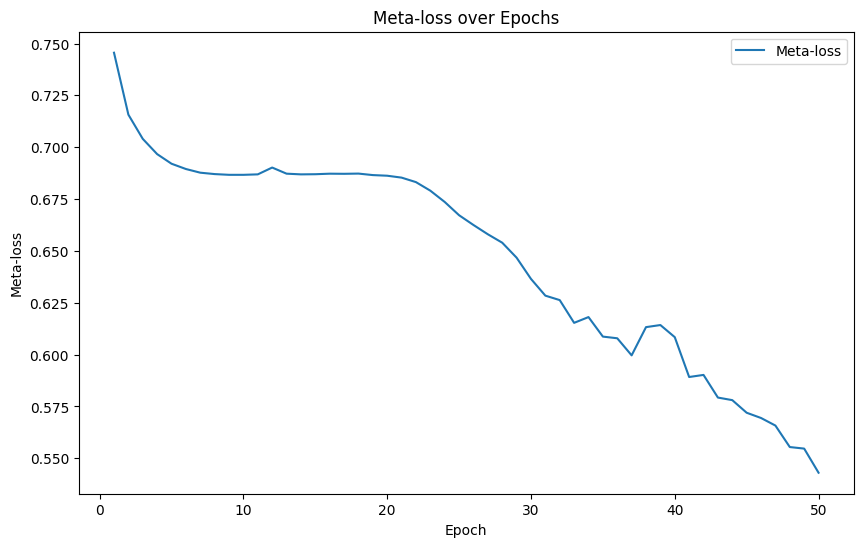

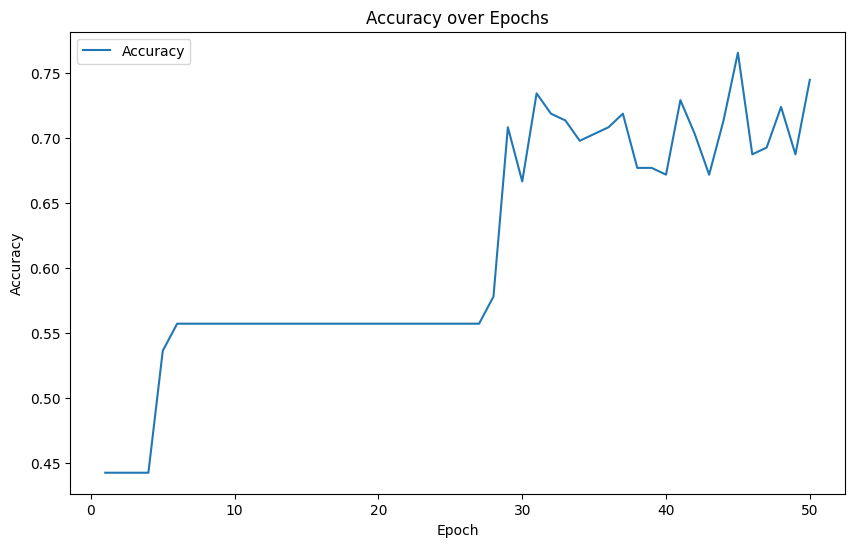

In [70]:
# Cell 10: Plotting and Metrics
def plot_training_results(results: Dict[str, List[float]]):
    """
    Plot training results including meta-loss and evaluation metrics.

    Args:
        results: Dictionary containing meta-loss and evaluation metrics.
    """
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Plot meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title("Meta-loss over Epochs")
    plt.legend()
    plt.show()

    # Plot evaluation metrics
    if config.EVAL_METRICS:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["accuracy"], label="Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy over Epochs")
        plt.legend()
        plt.show()

plot_training_results(training_results)

Classification Report:
               precision    recall  f1-score   support

       Quark       0.56      0.93      0.70      5000
       Gluon       0.79      0.25      0.38      5000

    accuracy                           0.59     10000
   macro avg       0.67      0.59      0.54     10000
weighted avg       0.67      0.59      0.54     10000



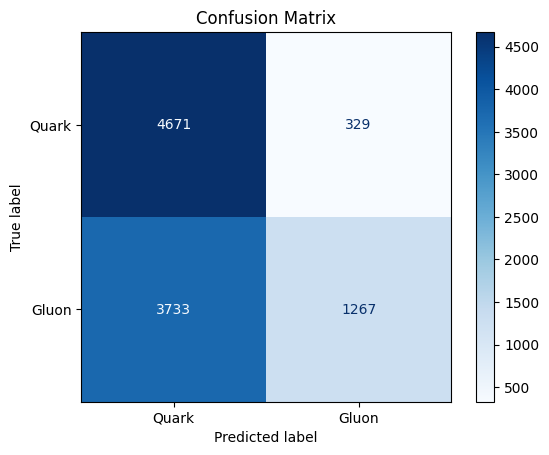

In [71]:
# Cell 11: Final Evaluation on Test2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_on_test2(model: nn.Module, test2_dataset: Dataset):
    """
    Evaluate the trained model on the test2 dataset.

    Args:
        model: The trained hybrid model.
        test2_dataset: The test2 dataset.

    Returns:
        None. Prints classification metrics and plots confusion matrix.
    """
    test2_loader = DataLoader(test2_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test2_loader:
            logits = model(X_batch)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute classification metrics
    report = classification_report(
        all_labels,
        all_preds,
        target_names=["Quark", "Gluon"],
        labels=[0, 1],
        zero_division=0
    )
    print("Classification Report:\n", report)

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])  # Ensure 2x2 shape
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Quark", "Gluon"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

if config.USE_TEST2:
    evaluate_on_test2(hybrid_model, test2_dataset)